# Bias while Performing Systematic Error Searches

When we performed systematic error searches in the first generation of the experiment, we would vary a large number of parameters (on the order of 100) and we looked to see if the EDM channel shifted varying this parameter. However, these measurements were complicated by the fact that if we saw an EDM shift that was marginally, though not clearly statistically significant, we would take more data to see if the effect went away, or became more statistically significant. In performing this operation, we are altering the probability distributions for the outcomes, but improving the rates of false positive and false negatives compared to the alternative where we only have a threshold.

The purpose of this document is to analyze quantitatively the effects of performing these conditional operations on the dataset.

In [1]:
import sys
sys.path.append('./code')

%matplotlib inline
import numpy as np
from statfunctions import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import erf, erfinv
sns.set_style('white')
sns.set_context('poster')

Lets say that we plan to perform $N=100$ tests, and each outcome $(x_i,\delta x_i)$ of these tests are are normally distributed. We are trying to determine which tests result in a non-zero value. To do this, we will put a threshold $x/\delta x|>n$ for some selected $n$. For a single measurement, the probability $P$ that $|x/\delta x|>n_{\rm min}$ is given by:
$$P\left(\left|\frac{x}{\delta x}\right|>n_{\rm min}\right) = \left(1-\rm{erf}\left(\left|\frac{x}{\sqrt{2}\delta x}\right|\right)\right)$$
So, for a given measurement, if we are alright being incorrect a proportion $p$ of the time, then we will set:
$$n_{\rm min}=\sqrt{2}~\rm{erf}^{-1}(1-p)$$ when trying to identify a systematic error. However, we are actually doing $N$ measurements, so we must also take into account the probability that we will falsely identify something as being non-zero. If we are satisfied with a probability $1-p$ that all of the measurements of the dataset will be within a threshold $n_{\rm max}$, then this threshold is given by:
$$n_{\rm max}=\sqrt{2}~\rm{erf}^{-1}((1-p)^{1/N})$$.
Hence, for a given probability level $p$, then we could say that we are not sure if the data is consistent with zero or not if $n_{\rm min}(p) < |x_i/\delta x_i| < n_{\rm max}(p)$, so instead of making a conclusion right away, we could take more data, and then average that data with the previous dataset

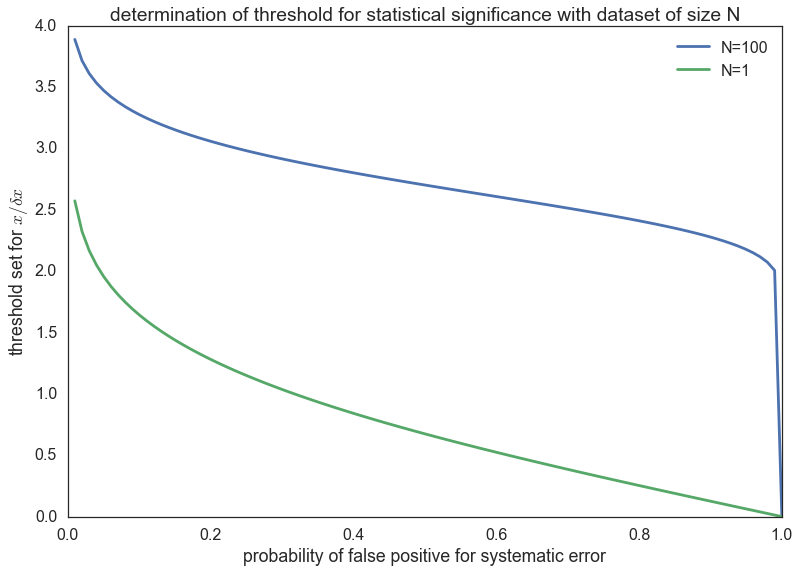

In [2]:
N = 100
p = np.linspace(0,1,100)
y1 = np.sqrt(2)*erfinv((1-p)**(1/float(N)))
y2 = np.sqrt(2)*erfinv((1-p))
plt.figure()
plt.plot(p,y1, label='N=100')
plt.plot(p,y2, label='N=1')
plt.xlabel('probability of false positive for systematic error')
plt.ylabel('threshold set for $x/\delta x$')
plt.title('determination of threshold for statistical significance with dataset of size N')
_= plt.legend()

so based on this argument, it seems reasonable to initially suspect data which is more than 1.65 sigma away from zero, and we can conclude that the effect is likely a real one if the data is more than 3.25 sigma away from zero.

In [6]:
N = 100
p = .10

n_max = np.sqrt(2)*erfinv((1-p)**(1/float(N)))
n_min = np.sqrt(2)*erfinv((1-p))

reps = 10000
cap  = 4

thresholds = [
    (n_min, n_max, None),
    (n_min, n_max, cap),
    (n_min, n_min, None),
    (n_max, n_max, None)
]

print(n_min, n_max)

(1.6448536269514722, 3.275955823959003)


Formalizing what I said before, this function an array of normal data with a given `mean`. On each iteration, for each entry in the array, if the statistical significance of a given entry is between `min_thresh` and `max_thresh`, then we take more data and average that data with the previous data to obtain better sensitivity. We can apply a `cap`, which is the maximum number of times that I can retake the data. In practice we seem to impliment a cap of about 4. This function then estimates which datapoints might be statistically significant by comparing them to `min_thresh`.

Here, I am using `min_thresh` to correspond to the statistical significance that corresponds to a 10% outcome on any given measurements, and I am using `max_thresh` to correspond to a 10% chance of an outcome within a set of 100 measurements.

In [4]:
def generate_data(size=5, min_thresh=1.645, max_thresh=3.276, mean=1.5, return_data=False, cap=None):
    
    x  = np.random.normal(size=(size,)) + mean
    dx = np.ones((size,))
    
    i=0
    while True:
        i += 1
        condition = np.logical_and(np.less(min_thresh, abs(x/dx)),
                                  np.less(abs(x/dx), max_thresh))
        

        if not(np.any(condition)):
            break
        else:
            X  = np.array([x[condition], np.random.normal(size=(sum(condition,))) + mean])
            dX = np.array([dx[condition], np.ones((sum(condition,),))])
            y, dy = weighted_mean(X, dX, axis=0)
            
            x[condition]  = y
            dx[condition] = dy
            
        if cap is not None:
            if i >= cap:
                break
            
    detection_probability = sum(abs(x/dx)>min_thresh)/float(size)
    if return_data:
        return x, dx
    else:
        return detection_probability

here I am performing 4 experiments:
   
1. I apply the conditional data taking and averaging operation if $n_{\rm min} < x/\delta x < n_{\rm max}$
2. Same as 1. but with a cap of 4 on the number of times you can take data for a given point.
3. Simple threshold rule with $n = n_{\rm min}$
4. Simple threshold rule with $n = n_{\rm max}$

In [53]:
means = np.linspace(0,5,30)
probs =[]*len(thresholds)
for mean in means:
    for i in range(len(thresholds)):
        p = generate_data(size=reps, min_thresh=thresholds[i][0], 
                          max_thresh=thresholds[i][1], mean=mean, cap=thresholds[i][2])
        try:
            probs[i].append(p)
        except:
            probs.append([p])

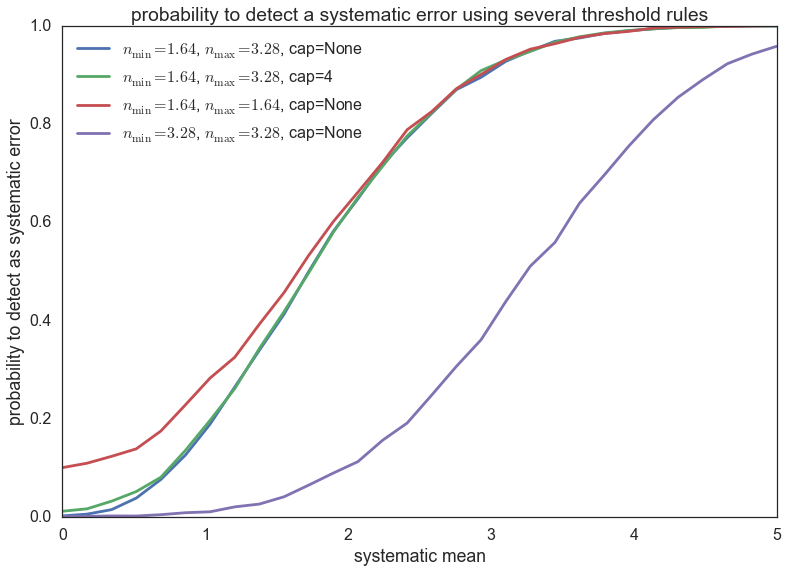

In [55]:
plt.figure()
for i in range(len(thresholds)):
    label = ('$n_{\\rm min}=' + ('%.3g' % thresholds[i][0])
             + '$, $n_{\\rm max}=' + ('%.3g' % thresholds[i][1]) +'$, cap='
             + str(thresholds[i][2]))
    plt.plot(means,probs[i],'-',label=label)
plt.axis([0,5,.001,1])
plt.xlabel('systematic mean')
plt.ylabel('probability to detect as systematic error')
plt.title('probability to detect a systematic error using several threshold rules')
#plt.yscale('log')
_ = plt.legend(loc='best')

The results above show that the conditional data-taking rule results in a low false positive rate (in the case that there is no systematic error) consistent with the threshold rule $n=n_{\rm max}$, and shows a low false negative rate (in the case that there is a systematic error) consistent with the threshold rule $n=n_{\rm min}$. Notice that the cap at 4$\times$ to retake data does not significantly change the behavior probability to detect an event as having arisen from a systematic error.

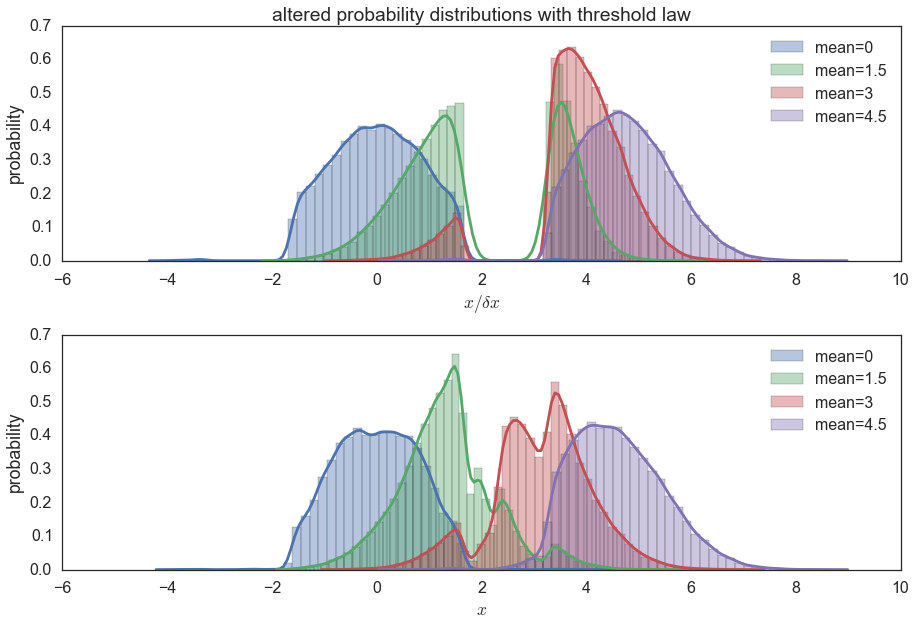

In [61]:
means = [0,1.5,3, 4.5]
fig = plt.figure()

for mean in means:
    x, dx = generate_data(size=50000, min_thresh=thresholds[0][0], 
                          max_thresh=thresholds[0][1], mean=mean, return_data=True)
    plt.subplot(2,1,1)
    sns.distplot(x/dx, label='mean='+str(mean))
    plt.subplot(2,1,2)
    sns.distplot(x, label='mean='+str(mean))
plt.subplot(2,1,1)
plt.xlabel('$x/\delta x$')
plt.ylabel('probability')
plt.title('altered probability distributions with threshold law')
_ = plt.legend(loc='best')
plt.subplot(2,1,2)
plt.xlabel('$x$')
plt.ylabel('probability')
_ = plt.legend(loc='best')
fig.tight_layout()

Here, you can see that the statistical distributions are severely warped after performing this conditional data taking operation. However, the median of the distribution is still unchanged as seen below.

In [12]:
means = np.linspace(0,5,30)

X = {'wm':[],'uwm':[],'m':[]}
dX = {'wm':[],'uwm':[],'m':[]}

for mean in means:
    x, dx = generate_data(size=5000, min_thresh=thresholds[0][0], 
                          max_thresh=thresholds[0][1], mean=mean, return_data=True)
    y, dy = weighted_mean(x, dx)
    z, dz = unweighted_mean(x, dx)
    w     = np.median(x)
    
    X['wm'].append(y)
    dX['wm'].append(dy)
    X['uwm'].append(z)
    dX['uwm'].append(dz)
    X['m'].append(w)

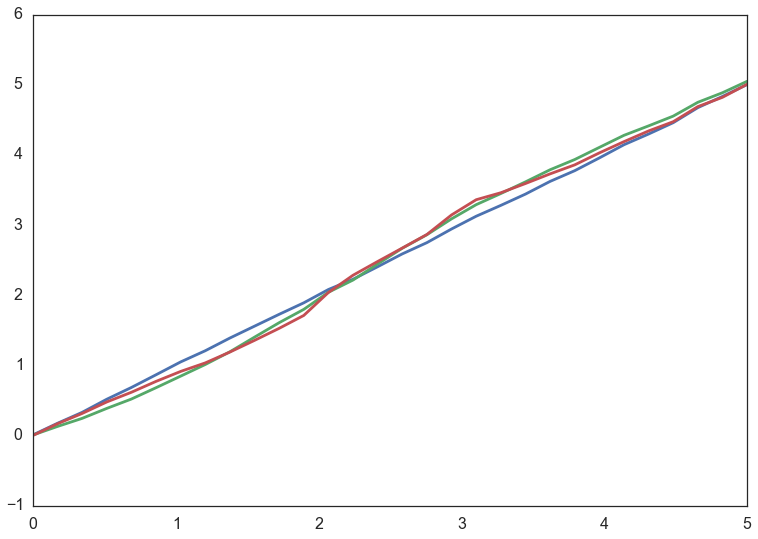

In [13]:
plt.plot(means,X['wm'])
plt.plot(means,X['uwm'])
plt.plot(means,X['m'])

In [ ]:
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=None, palette="muted", size=4,
           scatter_kws={"s": 50, "alpha": 1})

# Show the survival proability as a function of age and sex
g = sns.lmplot(x="age", y="survived", col="sex", hue="sex", data=df,
               palette=pal, y_jitter=.02, logistic=True)
g.set(xlim=(0, 80), ylim=(-.05, 1.05))

In [63]:
sns.lmplot?

In [65]:
from sklearn import linear_model

In [73]:
regr.fit?

In [2]:
x  = np.linspace(-1,1,10000)
dy = (1 + x**2) * np.ones(x.shape)
y  = dy * np.random.normal(size = x.shape) + x
x_model = [np.ones(x.shape), x]

regr = LinearRegression()
regr.fit(x_model,y,dy)
regr

		::: LINEAR REGRESSION MODEL :::
 
model:		a_{0}x_{0} + a_{1}x_{1}
 
best fit:	(-3.65+/-12.47)x10^(-3)x_{0} + (0.99+/-0.026)x_{1}
 
chi^2:		(0.985+/-0.014)

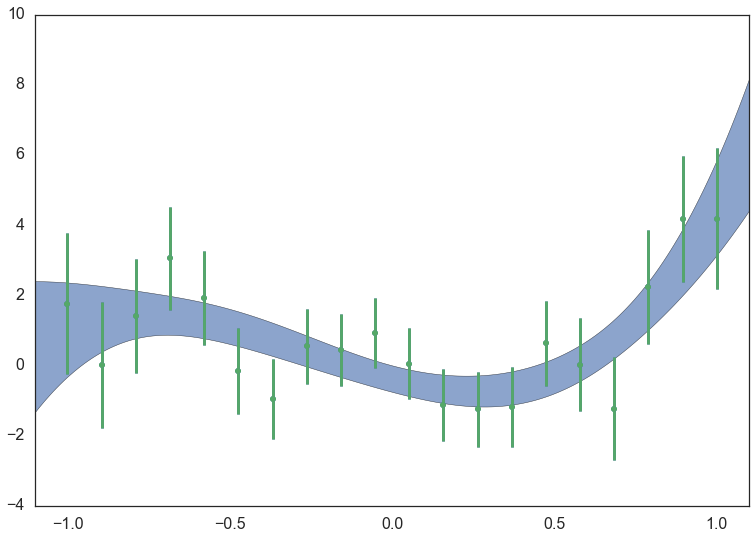

In [15]:
x  = np.linspace(-1,1,20)
dy = (1 + x**2) * np.ones(x.shape)
y1  = dy * np.random.normal(size = x.shape) + x
y2  = dy * np.random.normal(size = x.shape) + x**2
x_model = [np.ones(x.shape), x]


regr = [LinearRegression()]*2
regr[0].polynomial_fit(x,y1,dy, order=3)
regr[1].polynomial_fit(x,y2,dy, order=3)
regr[0].plot()
regr[1].plot()